In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, CountVectorizer, IDF,
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, sum

In [3]:
# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("apotek") \
    .getOrCreate()

# Load data CSV
df_dataset = spark.read.csv("/content/diabetes.csv", header=True, inferSchema=True)

#tampilkan data
df_dataset.show(5)


+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|Pregnancies|Glucose|BloodPressure|SkinThickness|Insulin| BMI|DiabetesPedigreeFunction|Age|Outcome|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
|          6|    148|           72|           35|      0|33.6|                   0.627| 50|      1|
|          1|     85|           66|           29|      0|26.6|                   0.351| 31|      0|
|          8|    183|           64|            0|      0|23.3|                   0.672| 32|      1|
|          1|     89|           66|           23|     94|28.1|                   0.167| 21|      0|
|          0|    137|           40|           35|    168|43.1|                   2.288| 33|      1|
+-----------+-------+-------------+-------------+-------+----+------------------------+---+-------+
only showing top 5 rows



In [6]:
# 1. Buat label klasifikasi berdasarkan kolom Outcome
# Jika Outcome adalah 1 (diabetes), label adalah 1; jika 0 (tidak diabetes), label adalah 0.
# Assuming Outcome is a binary classification column (0 or 1)
df_dataset = df_dataset.withColumn(
    "label",
    col("Outcome") # Directly use the Outcome column as the label
)

In [7]:
# 2. Transform Judul
tokenizer = Tokenizer(inputCol="Product", outputCol="words")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="title_features")

In [8]:
# 3. Transform State
State_indexer = StringIndexer(inputCol="State", outputCol="State_index", handleInvalid="keep")
State_encoder = OneHotEncoder(inputCol="State_index", outputCol="State_encoded")

In [9]:
# 4. Scaling a numerical feature
# Choose a relevant numerical feature from the diabetes dataset to scale.
# Let's choose 'Glucose' as an example.
Numerical_assembler = VectorAssembler(inputCols=["Glucose"], outputCol="Glucose_vec")
Numerical_scaler = StandardScaler(inputCol="Glucose_vec", outputCol="Glucose_scaled")


In [10]:
# 5. Gabungkan semua fitur menjadi vector features
# Update inputCols to reflect the features you are using from the diabetes dataset.
# Based on the current steps, we're only scaling 'Glucose'.
feature_assembler = VectorAssembler(
    inputCols=["Glucose_scaled"], # Using the scaled numerical feature
    outputCol="features"
)

In [11]:
# 6. Definisikan model klasifikasi RandomForest
# labelCol should match the name of the column containing your target variable ('label' in this case).
classifier = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

In [12]:
# 7. Buat pipeline lengkap
# Update the pipeline stages based on the steps you are actually performing.
pipeline = Pipeline(stages=[
    # Removed text processing stages
    # Removed categorical processing stages
    Numerical_assembler, # Add the numerical assembler
    Numerical_scaler, # Add the numerical scaler
    feature_assembler, # Add the feature assembler
    classifier # Add the classifier
])

In [13]:
# 8. Bagi data train-test split
train_df, test_df = df_dataset.randomSplit([0.8, 0.2], seed=42)

# 9. Latih model
model = pipeline.fit(train_df)

# 10. Prediksi di data test
predictions = model.transform(test_df)

In [14]:
# 11. Evaluasi akurasi
# Update the evaluator if your label classes are different from 0, 1, 2
# Since we used the 'Outcome' column (0 or 1), MulticlassClassificationEvaluator is still fine,
# it will work for binary classification as well.
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7479674796747967


In [15]:

# 12. Classification results display

# Add column label_name - Update the mapping based on your actual label values (0 and 1 for Outcome)
predictions = predictions.withColumn(
    "label_name",
    when(predictions.label == 0, "No Diabetes") \
    .otherwise("Diabetes") # Assuming label 1 corresponds to Diabetes
)

# (Opsional) Tambahkan juga prediksi label_name - Update the mapping based on your actual prediction values (0 and 1)
predictions = predictions.withColumn(
    "predicted_label_name",
    when(predictions.prediction == 0, "No Diabetes") \
    .otherwise("Diabetes") # Assuming prediction 1 corresponds to Diabetes
)

# Select columns to show - update these based on relevant columns in the diabetes dataset
predictions.select("Glucose", "BMI", "Outcome", "label_name", "prediction").show(100)


+-------+----+-------+-----------+----------+
|Glucose| BMI|Outcome| label_name|prediction|
+-------+----+-------+-----------+----------+
|     73|21.1|      0|No Diabetes|       0.0|
|     84|38.2|      0|No Diabetes|       0.0|
|     91|39.9|      0|No Diabetes|       0.0|
|     94| 0.0|      0|No Diabetes|       0.0|
|     98|25.2|      0|No Diabetes|       0.0|
|    101|21.9|      0|No Diabetes|       0.0|
|    102| 0.0|      0|No Diabetes|       0.0|
|    105|41.5|      0|No Diabetes|       0.0|
|    111|24.6|      0|No Diabetes|       0.0|
|    113|33.3|      1|   Diabetes|       0.0|
|    113|31.0|      0|No Diabetes|       0.0|
|    117|33.8|      0|No Diabetes|       0.0|
|    117|45.2|      0|No Diabetes|       0.0|
|    119|34.9|      0|No Diabetes|       0.0|
|    124|27.4|      1|   Diabetes|       0.0|
|    129|31.2|      0|No Diabetes|       0.0|
|    135|40.6|      0|No Diabetes|       0.0|
|    173|46.5|      0|No Diabetes|       1.0|
|      0|32.0|      0|No Diabetes|

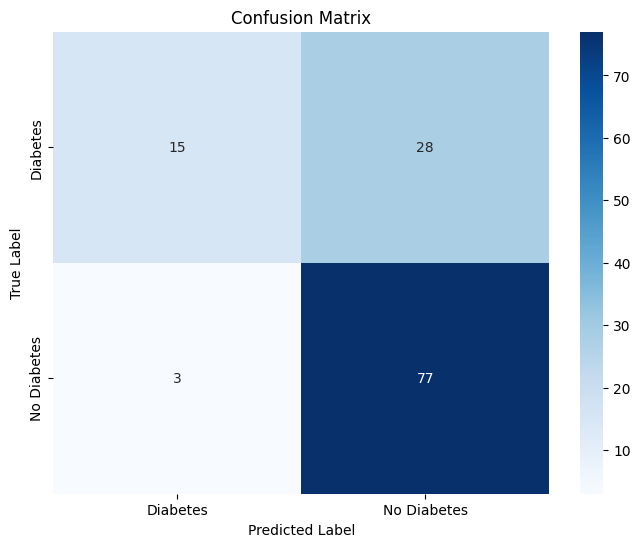

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Ensure scikit-learn and seaborn are installed if you haven't already
# !pip install scikit-learn seaborn matplotlib

# Konversi DataFrame PySpark ke Pandas
# Pilih kolom yang relevan untuk confusion matrix
pandas_df = predictions.select("label_name", "prediction").toPandas()

# Konversi kolom 'prediction' menjadi string agar sesuai dengan tipe data 'label_name'
# Use the same mapping as creating 'predicted_label_name'
pandas_df['prediction'] = pandas_df['prediction'].apply(
    lambda x: 'No Diabetes' if x == 0 else 'Diabetes'
)

# Confusion Matrix
# Gunakan string labels untuk kedua argumen
cm = confusion_matrix(pandas_df['label_name'], pandas_df['prediction'])
# Dapatkan unique labels dari kolom string
labels = sorted(pandas_df['label_name'].unique())

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
# Pastikan order label di heatmap sama dengan order di confusion matrix
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


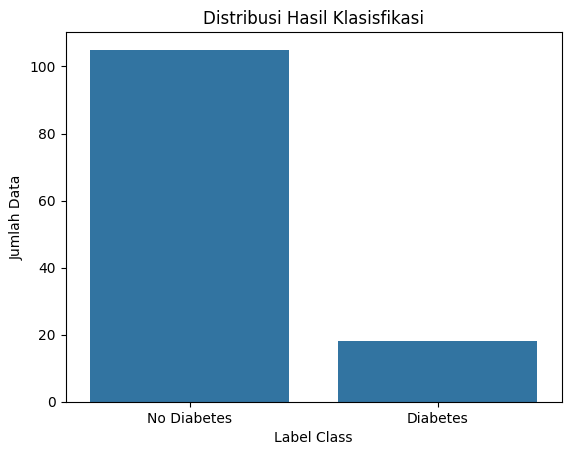

In [17]:
sns.countplot(x="prediction", data=pandas_df)
plt.title("Distribusi Hasil Klasisfikasi")
plt.xlabel("Label Class")
plt.ylabel("Jumlah Data")
plt.show()

In [22]:
# Select relevant columns from the diabetes dataset
save = predictions.select("Glucose", "BMI", "Outcome", "label", "prediction")
# Add mode="overwrite" to overwrite the file if it exists
save.write.csv("predictions.csv", header=True, mode="overwrite")